In [1]:
import pyspark

In [2]:
from wordcloud import WordCloud

In [3]:
import csv

In [4]:
import numpy as np

In [5]:
import pandas as pd

In [6]:
from pyspark import SparkConf,SparkContext,SQLContext

In [7]:
conf=SparkConf() #to create a sparkcontext,you have to create a sparkconf

In [8]:
context=SparkContext(conf=conf) #context creation

In [9]:
from pyspark.ml.feature import VectorAssembler

In [10]:
from pyspark.ml.feature import FeatureHasher


In [11]:
from pyspark.ml.feature import Tokenizer,HashingTF,IDF

In [12]:
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel



In [13]:
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel

In [14]:
from pyspark.mllib.util import MLUtils

In [15]:
from pyspark.ml import Pipeline


In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [17]:
from pyspark.sql.functions import col, lit


In [18]:
sql=SQLContext(context) #to import file you have to create a SQLContext

In [22]:
rddnew=context.textFile("/home/salman/Downloads/spamraw.csv") #importation of file

In [23]:
def vectorize_data(inputStr) :
    attribute_split = inputStr.split(",")
    spam_or_ham = 0.0 if attribute_split[0] == "ham" else 1.0
    return [spam_or_ham, attribute_split[1]]  #fonction to vectorize data 


In [24]:
vectorized = rddnew.map(vectorize_data) #to apply function ,we have to map it on rdd file

In [25]:
dfnew = sql.createDataFrame(vectorized, ["label", "message"]) #we create dataframe with the mapped file

In [24]:
dfnew.show() #show the dataframe

+-----+--------------------+
|label|             message|
+-----+--------------------+
|  1.0|                text|
|  0.0|Hope you are havi...|
|  0.0|K..give back my t...|
|  0.0|Am also doing in ...|
|  1.0|"complimentary 4 ...|
|  1.0|okmail: Dear Dave...|
|  0.0|Aiya we discuss l...|
|  0.0|Are you this much...|
|  0.0|Please ask mummy ...|
|  1.0|Marvel Mobile Pla...|
|  0.0| "fyi I'm at usf now|
|  0.0|"Sure thing big m...|
|  0.0|   I anything lor...|
|  0.0|    "By march ending|
|  0.0|           "Hmm well|
|  0.0|K I'll be sure to...|
|  0.0|Ha ha cool cool c...|
|  0.0|Darren was saying...|
|  0.0|He dint tell anyt...|
|  0.0|Up to u... u wan ...|
+-----+--------------------+
only showing top 20 rows



In [50]:
(training_data, test_data) = dfnew.randomSplit([0.7, 0.3]) #split the data into training and testing data 70 pourcent training and 30 

In [30]:
df=dfnew.toPandas() #dataframe to pandas compatible file

In [31]:
import matplotlib.pyplot as plt #importing matplotlib

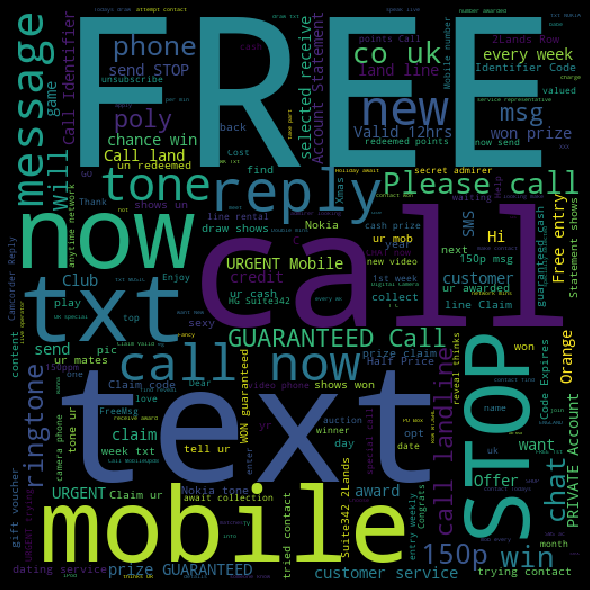

In [32]:
spam_words = ' '.join(list(df[df['label'] == 1]['message']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

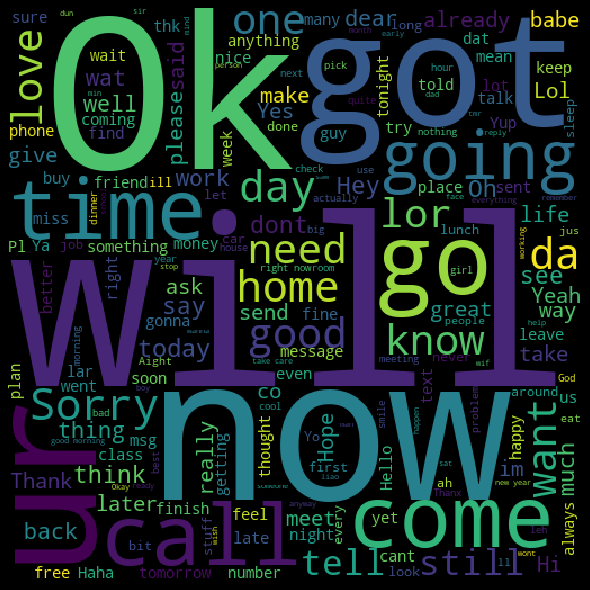

In [33]:
ham_words = ' '.join(list(df[df['label'] == 0]['message']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()


In [34]:
tokenizer = Tokenizer(inputCol="message",outputCol="tokenized") #tokenize the data

In [35]:
hasher = HashingTF(inputCol = tokenizer.getOutputCol(), outputCol = "frequency") #hash the data

In [36]:
idf = IDF(inputCol = hasher.getOutputCol(), outputCol = "features") #use the idf

In [37]:
from pyspark.ml.classification import RandomForestClassifier

In [38]:
from pyspark.ml.classification import LinearSVC

In [39]:
from pyspark.ml.classification import NaiveBayes

In [43]:
lsvc = LinearSVC(maxIter=10, regParam=0.1)

In [44]:
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)

In [45]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")


In [46]:
pipelinerf = Pipeline(stages=[tokenizer,hasher,idf,rf])

In [47]:
pipelinelsvc1 = Pipeline(stages=[tokenizer,hasher,idf,lsvc])

In [48]:
pipelinenb = Pipeline(stages=[tokenizer,hasher,idf,nb])

In [51]:
modelrf = pipelinerf.fit(training_data)

In [53]:
modellsvcc = pipelinelsvc1.fit(training_data)

In [54]:
modelnb = pipelinenb.fit(training_data)

In [55]:
predictionrf = modelrf.transform(test_data)

In [56]:
predictionlsvc= modellsvcc.transform(test_data)

In [72]:
predictionnb = modelnb.transform(test_data)

In [58]:
predictionnb.show()

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|label|             message|           tokenized|           frequency|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  0.0|" came to look at...|[", came, to, loo...|(262144,[35182,37...|(262144,[35182,37...|[-270.82132860625...|[1.0,2.0812627226...|       0.0|
|  0.0|"1) Go to write m...|["1), go, to, wri...|(262144,[35044,42...|(262144,[35044,42...|[-764.62693673510...|[1.0,1.2784849880...|       0.0|
|  0.0|"2 celebrate my b...|["2, celebrate, m...|(262144,[28092,37...|(262144,[28092,37...|[-303.89758123094...|[0.99999999975852...|       0.0|
|  0.0|"A cute thought f...|["a, cute, though...|(262144,[16332,23...|(262144,[16332,23...|[-806.25465108018...|[1.0,1.5743879022.

In [73]:
predictionnb1=predictionnb.toPandas()

In [74]:
def replace():
    for x in predictionnb1['prediction']:
        if x==0.0:
            predictionnb1['prediction'].replace(to_replace=[0.0], value='normal',inplace=True)
        elif x==1.0:
            predictionnb1['prediction'].replace(to_replace=[1.0],value="SPAM",inplace=True)
if __name__=='__main__':
    replace()

In [75]:
predictionnb1['prediction']

0       normal
1       normal
2       normal
3       normal
4       normal
         ...  
1635    normal
1636      SPAM
1637    normal
1638      SPAM
1639    normal
Name: prediction, Length: 1640, dtype: object

In [76]:
predictionnb1

,label,message,tokenized,frequency,features,rawPrediction,probability,prediction
0,0.0,""" came to look at the flat","["", came, to, look, at, the, flat]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-270.82132860625927, -355.2840022593078]","[1.0, 2.0812627226880057e-37]",normal
1,0.0,"""1) Go to write msg 2) Put on Dictionary mode ...","[""1), go, to, write, msg, 2), put, on, diction...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-764.6269367351015, -904.8389516338967]","[1.0, 1.2784849880593144e-61]",normal
2,0.0,"""2 celebrate my b’day","[""2, celebrate, my, b’day]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-303.8975812309436, -326.04182461981713]","[0.999999999758522, 2.414778442899705e-10]",normal
3,0.0,"""A cute thought for friendship: Its not necess...","[""a, cute, thought, for, friendship:, its, not...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-806.2546510801828, -849.5499012838143]","[1.0, 1.5743879022617487e-19]",normal
4,0.0,"""Ahhhh...just woken up!had a bad dream about u...","[""ahhhh...just, woken, up!had, a, bad, dream, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-546.0254895877214, -584.9062313167733]","[1.0, 1.301093223003534e-17]",normal
5,0.0,"""Aight","[""aight]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-51.200016424247906, -75.25228076298802]","[0.9999999999641711, 3.582896975310661e-11]",normal
6,0.0,"""Aight","[""aight]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-51.200016424247906, -75.25228076298802]","[0.9999999999641711, 3.582896975310661e-11]",normal
7,0.0,"""Aight","[""aight]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-51.200016424247906, -75.25228076298802]","[0.9999999999641711, 3.582896975310661e-11]",normal
8,0.0,"""Aight","[""aight]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-51.200016424247906, -75.25228076298802]","[0.9999999999641711, 3.582896975310661e-11]",normal
9,0.0,"""Aight","[""aight]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-51.200016424247906, -75.25228076298802]","[0.9999999999641711, 3.582896975310661e-11]",normal


In [65]:
selectedrf = predictionrf.select("label", "message", "probability", "prediction")

In [66]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")

In [67]:
accuracyrf = evaluator.evaluate(predictionrf)

In [68]:
accuracylsvc= evaluator.evaluate(predictionlsvc)

In [77]:
accuracynb= evaluator.evaluate(predictionnb)

In [79]:
print("Test set accuracy RANDOM FOREST = " + str(accuracyrf))


Test set accuracy RANDOM FOREST = 0.874390243902439


In [81]:
print("Test set accuracy LSVC = " + str(accuracylsvc))


Test set accuracy LSVC = 0.974390243902439


In [80]:
print("Test set accuracy NAIVE BAYES = " + str(accuracynb))

Test set accuracy NAIVE BAYES = 0.9658536585365853


In [120]:
accuracies=[accuracyrf,accuracynb,accuracylsvc]

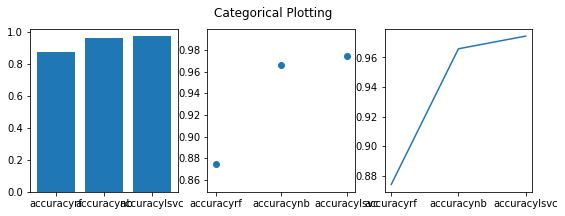

In [121]:
names = ['accuracyrf', 'accuracynb', 'accuracylsvc']
values = accuracies

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.bar(names, values)
plt.subplot(132)
plt.scatter(names, values)
plt.subplot(133)
plt.plot(names, values)
plt.suptitle('Categorical Plotting')
plt.show()

In [112]:
pdd=pd.DataFrame([["", "Gain a prize of 3000 usd"]], columns=("label","message"))

In [113]:
data=sql.createDataFrame(pdd)

In [114]:
predict=modelnb.transform(data)

In [115]:
predict.select("label","message","prediction").show()

+-----+--------------------+----------+
|label|             message|prediction|
+-----+--------------------+----------+
|     |Gain a prize of 3...|       1.0|
+-----+--------------------+----------+



In [116]:
p=predict.toPandas()

In [117]:

def replace():
    for x in p['prediction']:
        if x==0.0:
            p['prediction'].replace(to_replace=[0.0], value='normal',inplace=True)
        elif x==1.0:
            p['prediction'].replace(to_replace=[1.0],value="SPAM",inplace=True)
   
if __name__=='__main__':
    replace()

In [118]:
testpredict=p[["label","message","prediction"]]

In [119]:
predictiontest=sql.createDataFrame(testpredict).show()

+-----+--------------------+----------+
|label|             message|prediction|
+-----+--------------------+----------+
|     |Gain a prize of 3...|      SPAM|
+-----+--------------------+----------+

